In this notebook, we will be plotting the performance of RefCM across all currently available datasets, as well as testing what parameters yield the best performance.

In [1]:
import sys
sys.path.append('../src/')

import os
import json
import config
import logging
import numpy as np
import scanpy as sc
from refcm import RefCM

config.start_logging(logging.DEBUG)

In [2]:
%load_ext autoreload
%autoreload 2

/var/folders/n3/d8yl0jxx2vl98cxyn9bljg6m0000gn/T/ipykernel_35907/3535306614.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


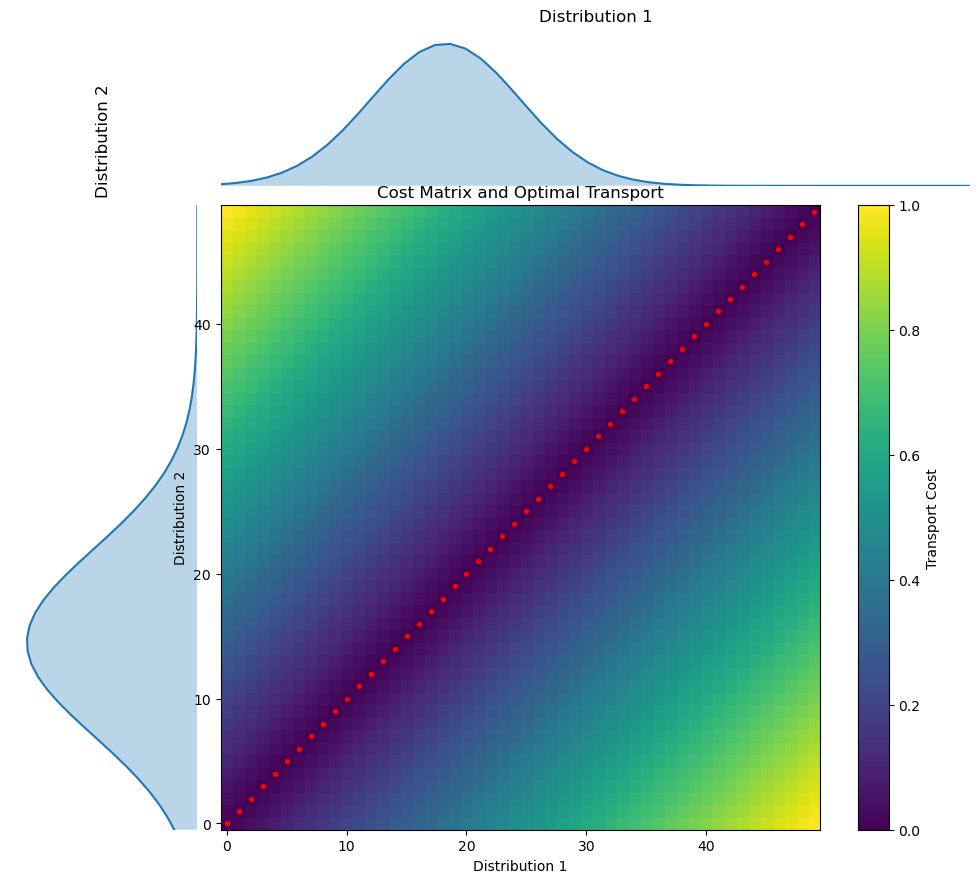

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import linear_sum_assignment

# Set random seed for reproducibility
np.random.seed(42)

# Generate sample points
n_points = 50
x = np.linspace(0, 1, n_points)

# Create two different probability distributions
dist1 = norm.pdf(x, loc=0.3, scale=0.1)
dist2 = norm.pdf(x, loc=0.7, scale=0.15)

# Normalize the distributions
dist1 /= dist1.sum()
dist2 /= dist2.sum()

# Compute cost matrix
cost_matrix = np.abs(x[:, np.newaxis] - x[np.newaxis, :])

# Solve the optimal transport problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create the main figure
fig = plt.figure(figsize=(12, 10))

# Define grid for subplots
gs = fig.add_gridspec(2, 2, width_ratios=[1, 4], height_ratios=[1, 4],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create subplots
ax_top = fig.add_subplot(gs[0, 1])
ax_left = fig.add_subplot(gs[1, 0])
ax_main = fig.add_subplot(gs[1, 1])

# Plot distribution 1 on top
ax_top.plot(x, dist1)
ax_top.fill_between(x, dist1, alpha=0.3)
ax_top.set_title('Distribution 1')
ax_top.set_xlim(0, 1)
ax_top.set_ylim(0, max(dist1) * 1.1)
ax_top.axis('off')

# Plot distribution 2 on left (rotated 180 degrees)
ax_left.plot(dist2[::-1], x)
ax_left.fill_betweenx(x, dist2[::-1], alpha=0.3)
ax_left.set_title('Distribution 2', rotation=90, va='bottom')
ax_left.set_ylim(0, 1)
ax_left.set_xlim(max(dist2) * 1.1, 0)  # Reverse x-axis
ax_left.axis('off')

# Plot heatmap of cost matrix
im = ax_main.imshow(cost_matrix, cmap='viridis', aspect='auto', origin='lower')
ax_main.set_title('Cost Matrix and Optimal Transport')
ax_main.set_xlabel('Distribution 1')
ax_main.set_ylabel('Distribution 2')

# Add colorbar
cbar = fig.colorbar(im, ax=ax_main)
cbar.set_label('Transport Cost')

# Plot optimal transport connections
for i, j in zip(row_ind, col_ind):
    ax_main.plot([j, j], [i, i], 'r.', markersize=5)

plt.tight_layout()
plt.show()

All currently tested datasets, and their associated .obs clustering key:

In [3]:
DSS = {
    # # celltypist datasets
    "Blood": "cell_type",
    "Bone_marrow": "cell_type",
    "Heart": "cell_type",
    # "Hippocampus": "cell_type",
    "Intestine": "cell_type",
    "Kidney": "cell_type",
    "Liver": "cell_type",
    "Lung": "cell_type",
    "Lymph_node": "cell_type",
    "Pancreas": "cell_type",
    "Skeletal_muscle": "cell_type",
    "Spleen": "cell_type",
    
    # # gut atlas
    "gut_atlas_tcell": "annotation",
    
    # Allen-Brain datasets
    "ALM": "labels34",
    "MTG": "labels34",
    "VISp": "labels34",
    
    # pbmc datasets
    "pbmc_10Xv2": "labels",
    "pbmc_10Xv3": "labels",
    "pbmc_CEL-Seq": "labels",
    "pbmc_Drop-Seq": "labels",
    "pbmc_inDrop": "labels",
    "pbmc_Seq-Well": "labels",
    "pbmc_Smart-Seq2": "labels",
    
    # pancreas datasets
    "pancreas_celseq": "celltype",
    "pancreas_celseq2": "celltype",
    "pancreas_fluidigmc1": "celltype",
    "pancreas_indrop1": "celltype",
    "pancreas_indrop2": "celltype",
    "pancreas_indrop3": "celltype",
    "pancreas_indrop4": "celltype",
    "pancreas_smarter": "celltype",
    "pancreas_smartseq2": "celltype",
    
    # LGN datasets
    "LGN_human_intron": "cluster_label",
    "LGN_human_exon": "cluster_label",
    "LGN_macaque_intron": "cluster_label",
    "LGN_macaque_exon": "cluster_label",
    "LGN_mouse_intron": "cluster_label",
    "LGN_mouse_exon": "cluster_label",
}

Use the below codeblock to test out certain parameters (or think how you could automate a grid-like parameter-search) to determine which choice might yield the best results (and why that may be the case?).

In [4]:
# query / reference dataset choice
q_id = 'LGN_human_intron'
ref_id = 'LGN_macaque_intron'

q_ds = sc.read_h5ad(f'../data/{q_id}.h5ad')
ref_ds = sc.read_h5ad(f'../data/{ref_id}.h5ad')

# the parameters to tune
rcm = RefCM(target_sum=1e6, discovery_threshold=0.5, max_splits=3)

# evaluation / display
m = rcm.annotate(q_ds, q_id, ref_ds, ref_id, DSS[q_id], DSS[ref_id])
perf = m.eval(DSS[q_id])
m.display_matching_costs(DSS[q_id])

[h5py._conv      ] [DEBUG   ] : Creating converter from 3 to 5


KeyboardInterrupt: 

If you have found better parameters for a certain query -> reference pair, enter these under the `params.json` file. In the example above, this would mean editing line 485 to: 

```json
    ...
    "LGN_human_intron": {
            ...
            "LGN_macaque_intron": {"target_sum": 1000000, "discovery_threshold": 0.5, "max_splits": 3},
            ...
    }
    ...
```

More importantly, think about the characteristics that make one mapping "better" than another. How can you quantify this, and express it as an equation? Once you have found a satisfying definition (equivalently loss or utility function), try to automate searching for the best parameters for all combinations.

In [ ]:
# define the loss function associated to 

To see the performance metrics already available to you, check the results of running `m.eval()` (stored in `perf` above). For more documentation, check `src/matchings.py`.

In [ ]:
perf

{'common': ['GABA1', 'GABA2', 'GABA3', 'K1', 'K2'],
 'n_common': 5,
 'counts': {'Astro': 49,
  'GABA1': 56,
  'GABA2': 60,
  'GABA3': 26,
  'K1': 65,
  'K2': 39,
  'MP': 706,
  'Micro': 22,
  'OPC': 24,
  'Oligo': 162},
 'counts_total': 1209,
 'counts_total_common': 246,
 'counts_total_noncommon': 963,
 'n_correct_links': 4,
 'n_incorrect_links': 5,
 'n_notmapped_links': 81,
 'common_w_correct_links': ['GABA1', 'GABA2', 'GABA3', 'K2'],
 'n_common_w_correct_links': 4,
 'pct_common_w_correct_links': 0.7357723577235772,
 'common_w_only_correct_links': ['GABA1'],
 'n_common_w_only_correct_links': 1,
 'pct_common_w_only_correct_links': 0.22764227642276422,
 'common_w_incorrect_links': ['GABA2', 'GABA3', 'K1', 'K2'],
 'n_common_w_incorrect_links': 4,
 'pct_common_w_incorrect_links': 0.7723577235772358,
 'common_w_only_incorrect_links': ['K1'],
 'n_common_w_only_incorrect_links': 1,
 'pct_common_w_only_incorrect_links': 0.26422764227642276,
 'common_w_correct_and_incorrect_links': ['GABA2', '

With the parameters available in `params.json`, we can then view our performance across all dataset combinations as follows:

In [ ]:
with open('params.json', 'r') as f:
    params = json.load(f)

In [ ]:
# performance log across the datasets
perfs = [[None for _ in DSS] for _ in DSS]


# mapping all different combinations
for i, (a_id, a_key) in enumerate(DSS.items()):
    a_ds = sc.read_h5ad(f'../data/{a_id}.h5ad')
    
    for j, (b_id, b_key) in enumerate(DSS.items()):
        if j < i:
            continue
        
        b_ds = sc.read_h5ad(f'../data/{b_id}.h5ad')
        
        # run first with a as query and b as reference, then b as query and a as reference
        # to avoid re-reading certain files as often.
        
        rcm = RefCM(**params[a_id][b_id])
        m = rcm.annotate(a_ds, a_id, b_ds, b_id, DSS[b_id], DSS[a_id])
        perfs[i][j] = m.eval(ground_truth_obs_key=DSS[a_id])
        
        if i == j:
            continue
        
        rcm = RefCM(**params[b_id][a_id])
        m = rcm.annotate(b_ds, b_id, a_ds, a_id, DSS[a_id], DSS[b_id])
        perfs[j][i] = m.eval(ground_truth_obs_key=DSS[b_id])

[refcm           ] [INFO    ] : NOTE: raw counts expected in anndata .X attributes.
[refcm           ] [DEBUG   ] : Loading cached mapping costs from ws_cache.json.
[refcm           ] [DEBUG   ] : Using costs for Blood->Blood found in cache.
[refcm           ] [DEBUG   ] : starting LP optimization
[refcm           ] [DEBUG   ] : optimization terminated w. status "Optimal"
[matchings       ] [DEBUG   ] : [+] CD16-negative, CD56-bright natural killer cell, human mapped to CD16-negative, CD56-bright natural killer cell, human
[matchings       ] [DEBUG   ] : [+] CD16-positive, CD56-dim natural killer cell, human mapped to CD16-positive, CD56-dim natural killer cell, human
[matchings       ] [DEBUG   ] : [+] central memory CD4-positive, alpha-beta T cell mapped to central memory CD4-positive, alpha-beta T cell
[matchings       ] [DEBUG   ] : [+] central memory CD8-positive, alpha-beta T cell mapped to central memory CD8-positive, alpha-beta T cell
[matchings       ] [DEBUG   ] : [+] class s

KeyboardInterrupt: 

In [ ]:
from typing import Dict, Tuple, List, Callable

metric_name = "pct_common_clusters_correctly_linked"
def metric(perf_log: Dict) -> float:
    return perf_log['n_common_w_correct_links'] / perf_log['n_common'] if perf_log['n_common'] != 0 else 1.0

In [ ]:
import plotly.express as px

def display_performance(perfs: List[List[Dict]], metric_name: str, metric: Callable[[Dict], float]) -> None:
    
        title = metric_name

        y_label = "Query"
        x_label = "Reference"
        
        ps = list(map(lambda row: list(map(metric, row)), perfs))

        # plot the matching costs
        fig = px.imshow(
            ps,
            title=title,
            labels=dict(y=y_label, x=x_label, color="performance"),
            x=list(DSS.keys()),
            y=list(DSS.keys()),
            color_continuous_scale="Agsunset",
        )
        fig.update_xaxes(tickangle=-45)

        fig.show()

In [ ]:
display_performance(perfs, metric_name, metric)

In [ ]:
for i in range(len(DSS)):
    for j in range(len(DSS)):
        if metric(perfs[i][j]) != metric(perfs[j][i]):
            print(i, list(DSS.keys())[i], j, list(DSS.keys())[j])

0 Blood 4 Lymph_node
0 Blood 7 Spleen
1 Bone_marrow 3 Lung
1 Bone_marrow 4 Lymph_node
1 Bone_marrow 7 Spleen
2 Heart 7 Spleen
3 Lung 1 Bone_marrow
3 Lung 4 Lymph_node
4 Lymph_node 0 Blood
4 Lymph_node 1 Bone_marrow
4 Lymph_node 3 Lung
4 Lymph_node 7 Spleen
6 Skeletal_muscle 7 Spleen
7 Spleen 0 Blood
7 Spleen 1 Bone_marrow
7 Spleen 2 Heart
7 Spleen 4 Lymph_node
7 Spleen 6 Skeletal_muscle
7 Spleen 14 pbmc_CEL-Seq
7 Spleen 15 pbmc_Drop-Seq
7 Spleen 16 pbmc_inDrop
7 Spleen 17 pbmc_Seq-Well
7 Spleen 18 pbmc_Smart-Seq2
14 pbmc_CEL-Seq 7 Spleen
15 pbmc_Drop-Seq 7 Spleen
16 pbmc_inDrop 7 Spleen
17 pbmc_Seq-Well 7 Spleen
18 pbmc_Smart-Seq2 7 Spleen
